# Introduction

CMB-ML manages a complex pipeline that processes data across multiple stages. Each stage produces outputs that need to be tracked, reused, and processed in later stages. Without a clear framework, this can lead to disorganized code, redundant logic, and errors.

The CMB-ML library provides a set of tools to manage these pipelines in a modular way. Each tool focuses on a specific task, such as handling data files, managing file paths, or defining pipeline stages. Together, they simplify building and maintaining complex workflows.

In previous notebooks the [elements of an Executor](demonstrations/E_CMB_ML_framework.ipynb) and [assembly of Executors](demonstrations/F_CMB_ML_pipeline.ipynb) were described. The example stages were very simple - they ingested a single input and produced a single output. A primary motivation of the CMB-ML library is to handle multiple simulations, which requires going beyond that basic pattern. In this notebook, I illustrate how that can be done.

There are several different ways to structure an Executor, depending on the type of processing performed in the current stage. Those stages and some examples for each are:
- Basic Executors, appropriate when outputting a single instance
    - A global output, used across all simulations
    - A check of configuration parameters (during setup)
    - Summarizing data across all simulations (at the end of Analysis)
- Serially Iterating Executors, conceptually easy, though possibly inefficient
    - Processes that use outside libraries which already use multiple threads
    - Processes that are only run a small number of times, like creating result figures
- Parallel Iterating Executors, are a bit more complicated but much faster
    - Processes which are individually simple, using only a single thread
- PyTorch-centric Executors, when using PyTorch Datasets and DataLoaders
- Matplotlib-centric Executors, when displaying results

This notebook also serves to illustrate different stages in the pipeline YAML and different ways that `Asset`s are used.

## Example

In this notebook, I'll continue with the example of converting a power spectrum into a map. I'll consider a series of stages to create and preprocess some "CMB" maps. Those stages are to:
- Produce a power spectrum
- Produce maps from the spectrum, divided into multiple simulations and multiple splits
- Determine global minimum and maximum values across maps in two of the splits (e.g., when the Test split should be blind)
- Preprocess (MinMax Scale) maps

This is a contrived example. It should give a reasonable overview of different techniques. At the end I'll point out some other examples in the wild.

Two datasets are created as examples. The first is only 9 maps at $\textrm{N}_\textrm{side}=32$, taking up 1.7 MB ("Dataset_32"). The other contains 120 maps at $\textrm{N}_\textrm{side}=256$, taking up 1.6 GB ("Dataset_256"). There is no utility in that data beyond the demonstrations here (you can safely delete them).

## Contents

This notebook has these two preliminary sections:
- [Set-Up](#set-up)
- [Dataset Splits](#dataset-splits) (introducing the `Split` object)

Then each of the patterns will be illustrated with a different stage of the pipeline

- Produce a power spectrum: [Basic Executor](#basic-executor-making-a-power-spectrum)
- Produce CMB maps from spectra: [Serial Iteration Executor](#serially-iterating-executor-converting-a-spectrum-to-map-realizations)
- Determine global minimum and maximum values: [Parallel Iteration Executor](#parallel-executor)
- Preprocessing maps: [PyTorch Dataset-centered Executor](#pytorch-dataset-centric-executors)

In the [Conclusion](#conclusion) I provide links to examples of these executors in the modules for PyILC, cmbNNCS, and the Patch NN methods.

## Set-Up

I have to again set a few things up so that the CMB-ML framework plays nice with Jupyter.

In [1]:
# Ignore this cell. 
# It's needed for the notebook to work, not something to learn.

import sys
import os

# Set the local_system
os.environ["CMB_ML_LOCAL_SYSTEM"] = "generic_lab"

# Add the path to the parent directory so I can import cmb-ml
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.insert(0, repo_root)

In [2]:
import logging
from hydra import compose, initialize
import numpy as np
import healpy as hp

from cmbml.core import PipelineContext
from cmbml.core import BaseStageExecutor, Asset
from cmbml.core.asset_handlers import TextPowerSpectrum, HealpyMap, Config

In [3]:
logger = logging.getLogger("F_Tutorial")
logger.setLevel(logging.DEBUG)

# Outside of a notebook, Hydra will handle the logging. 
handler = logging.StreamHandler()  # StreamHandler sends logs to sys.stdout by default
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)

In [4]:
from omegaconf import OmegaConf
from hydra.core.hydra_config import HydraConfig

# There are better ways to do this outside of notebooks.
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoG_framework", return_hydra_config=True)
    HydraConfig.instance().set_config(cfg)

I will also be using astropy units. This allows tracking of temperature units: e.g., $\mu\textrm{K}_\textrm{CMB}$, or $\textrm{K}_\textrm{RJ}$, or $\textrm{MJy}/\textrm{sr}$.

In [5]:
import pysm3.units as u

# Dataset Splits


## YAML Configuration

The CMB-ML dataset is split into Training, Validation, and Test subsets. The size of each split is set in a [split.yaml](../cfg/splits/3-3.yaml) configuration file (there are many). For instance,

In [6]:
print(OmegaConf.to_yaml(cfg.splits))

name: 3-3
Train:
  n_sims: 3
Valid:
  n_sims: 3
  n_sims_cap: ${n_infer_cap}
Test:
  n_sims: 3
  n_sims_cap: ${n_infer_cap}
run_inference_on: ${run_inference_on}



- `name`: The name of the splits is used for dataset names
  - For small, debugging, splits I will use 3-3 to mean three splits with three simulations each.
  - For larger, more practical, splits I will use the total number of simulations (e.g., 1450 or 2450)
- `Train` / `Valid` / `Test`: The name of a split
  - CMB-ML can also use `Test1`, `Test2`, etc., if different test distributions are to be examined
  - Use of other split names would need to be matched elsewhere in configurations an possibly in Python
- `n_sims`: The total number of simultions in this split
- `n_sims_cap`: When debugging, it is faster to run inference on a portion of the dataset only. This key enables that.
  - `${n_infer_cap}` causes Hydra to interpolate the value (get it from elsewhere). In this case, it will look for `n_infer_cap` in the top level configuration. This is a shortcut I use so that the parameter can be in the correct place in the configuration YAMLs, but I can change it more easily at a single location.
- `run_inference_on`: Whether to run Prediction (and later) stages on "Test" or "Valid" data. I try to use "Test" only for final runs, and "Validation" while developing.
  - Again, this parameter is set at the top level, but I believe it "belongs" here. When I need to use it, I refer to `cfg.splits.run_inference_on`, and not the top-level `cfg.run_inference_on`.

Some stages of the pipeline may only apply to certain splits. For instance, when predicting results, I don't need to run on the training datasplit. In this case, the [patch_nn pipeline YAML](../cfg/pipeline/pipe_model_patch_nn.yaml) has a key to note this:
```yaml
    predict: &final_inference
      assets_out:
        cmb_map: 
          handler: HealpyMap
          path_template: "{root}/{dataset}/{working}{stage}/{split}/{sim}/cmb_map_pred_{epoch}.fits"
      assets_in:
        obs_maps: {stage: make_sims}
        lut: {stage: make_lut}
        dataset_stats: {stage: get_dataset_stats}
        model: {stage: train}
      splits:
        - ${splits.run_inference_on}
      epochs: ${use_epochs}
      dir_name: PatchNN_F_Predict
      make_stage_log: True
```

The lines
```yaml
      splits:
        - ${splits.run_inference_on}
```
tell the Executor to only run on the split marked that way in the splits YAML.

Similar patterns can be seen elsewhere. For instance, the preprocessing stage for the [patch_nn pipeline](../cfg/pipeline/pipe_model_patch_nn.yaml) is only applied to the Training and Validation datasplits; in this particular case, preprocessing of the Test datasplit occurs during inference.

## `Split` object

To handle splits within executors, we have the `Split` class. An instance of this class is created for each split. It retains the name and number of simulations. It could be extended to track additional variables. It has a method, `iter_sims()` that produces an iterator over all simulations within the split (referring to each simulation as an integer index):

<!-- Generally, splitting of a dataset is done by producing one full dataset and randomly assigning elements to the different splits. The current system does this in effect, because it draws each simulation at random from a hypothetical source distribution. I do generate them pre-labelled into a category, but this is immaterial. -->

<!-- When the project was started, I wanted to investigate the impact of different distributions on both training and inference.
This may be picked up again in the future. 
There are vestiges of this intention in the code, such as the ps_fidu_fixed parameter within a split. This would enable me to use a set of simulations with a single fiducial power spectrum, checking where a trained model struggles. -->

In [7]:
from cmbml.core import Split

split = Split("Train", cfg.splits.Train)
print(f"Split name: {split.name}")
print(f"Number of sims: {split.n_sims}. \nThey are: ")
for s in split.iter_sims():
    print(f"{s:>4}")
del s, split

Split name: Train
Number of sims: 3. 
They are: 
   0
   1
   2


# Basic Executor: Making a Power Spectrum

The first stage in this demonstration pipeline will produce a single power spectrum and save it to disk.

I start with the definition of the stage in the pipeline YAML. In this case, it's the same as was done previously:

In [8]:
print(OmegaConf.to_yaml(cfg.pipeline.ps_setup))

assets_out:
  cmb_ps:
    handler: TextPowerSpectrum
    path_template: '{root}/{dataset}/{stage}/cmb_dummy_ps.fits'
dir_name: A_PS_Setup



I've made some adjustments from the [previous version](F_CMB_ML_pipeline.ipynb#set-up) of this executor:

In [9]:
class MakePSExecutor(BaseStageExecutor):
    def __init__(self, cfg):
        super().__init__(cfg, stage_str="ps_setup")

        self.out_cmb_ps: Asset = self.assets_out["cmb_ps"]
        out_cmb_ps_handler: TextPowerSpectrum  # Reference to the handler

        # "Power spectrum model" as a parameter
        self.ps_model = cfg.model.ps
        self.ells = cfg.model.max_ell

    def execute(self):
        # The following logging line is always used at the start of an execute() method:
        logger.debug(f"Running {self.__class__.__name__} execute()")

        ell = np.arange(self.ells)
        # Create the power spectrum from the model
        ps = np.poly1d(self.ps_model)
        self.out_cmb_ps.write(data=ps(ell))
        logger.debug(f"CMB power spectrum written to {self.out_cmb_ps.path}")

One change is to include a reference to the handler used for the asset. The line:
```python
        out_cmb_ps_handler: TextPowerSpectrum
```
doesn't have any impact on the way the code runs. Python sees that the variable is never used, so there's only negligible computational cost to including it. However, it has a huge benefit to me as I write an Executor: I can very quickly find the code for this particular AssetHandler using my IDE. <!-- This pattern has a huge flaw: duplication. There's NOTHING that forces the handler listed to match the one in the config file. I have ideas for better solutions to this, but haven't implemented any. This reflects a short-coming of using Hydra, since the class of the asset handler isn't in a form IDE's currently recognize -->

In this case, I'm getting the power spectrum as a polynomial model fit to a small range of the data. Previously, those were hard-coded values. Here, I've remove the hard-coding. This gives me more flexibility. Instead, the spectrum is included as a parameter from the configuration file $^\dagger$. 

$^\dagger$<sub>This is not the correct way to generate a power spectrum, it's just what's suitable for a small demonstration. Also, the model is more "data" than a "parameter"; hard-coding it into the configuration isn't the best idea. Instead, I'd prefer to save it to a text file and use an Asset to manage the values. That makes this more extensible. </sub>

When creating executors I strive to **set variables in the `__init__`** method, pulling values from the configurations. 

Early on when I was putting together CMB-ML, I simply had
```python
        self.cfg = cfg  # Do not do this!
```
in my executors. This defers pulling what I need from the configurations until the `execute()` function. It seems simpler, but really bit me when a reference to the configuration was incorrect (e.g. "cfg.model.power_spectrum" instead of "cfg.ps_model"). That would cause the executor to crash. Instead, by setting class variables for everything I need in the `__init__()` method, I fail faster during `prerun_pipeline()` and simplify debugging. <!-- ideally, I would take this to a next level, and have more extensive validation of the Hydra configs -->

I've also added the use of `logger`. I try to use it sparingly.

I check each stage to ensure they work individually. When I do this, I use small scale (debugging) settings so it can test the code more quickly. The current configuration, for example, has this running for only three simulations per split, and at a low $\textrm{N}_\textrm{side}=32$.

The following cell runs the executor alone and works for notebooks. When developing Python modules, I usually use my top-level script and comment or un-comment the appropriate executors.

In [10]:
executor = MakePSExecutor(cfg)
executor.execute()

Running MakePSExecutor execute()
CMB power spectrum written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/A_PS_Setup/cmb_dummy_ps.fits


I now have a power spectrum and can move on to the next stage.

# Serially Iterating Executor: Converting A Spectrum to Map Realizations

Now I need to create many map realizations using the previously created spectrum. This is similar to what was done in the [previous notebook](demonstrations/E_CMB_ML_framework.ipynb), but now it is being done for many simulations across datasplits.

## Configuration YAML

I start with my pipeline configuration. What's going in and out of the stage?

The [first pipeline YAML](../cfg/config_demoE_framework.yaml) had the following:
```yaml
    ps2map:
      assets_out:
        cmb_map:
          handler: HealpyMap
          path_template: "{root}/{dataset}/{stage}/cmb_dummy_map.fits"
      assets_in:
        cmb_ps: {stage: ps_setup}
      dir_name: B_CMB_Map
```

The new pipeline YAML has this, instead:
```yaml
    ps2map:
      assets_out:
        cmb_map:
          handler: HealpyMap
          path_template: "{root}/{dataset}/{stage}/{split}/{sim}/cmb_map.fits"
      assets_in:
        cmb_ps: {stage: ps_setup}
      dir_name: B_CMB_Map
      splits:
        - train
        - valid
        - test
```
Note that the changes are minimal:
- The `path_template` has changed so that filepaths include the names of the split and simulation. 
- I define which splits are operated upon.

Returning to the question "What's going in and out of this stage?", I see that it's the exact same thing as before, which explains why the changes to the pipeline YAML are minimal.

## Executor

More changes are needed in Python. Recall the previous version of the Executor:

```python
    class PS2MapExecutor(BaseStageExecutor):
        def __init__(self, cfg) -> None:
            super().__init__(cfg, stage_str="ps2map")

            self.out_map_asset = self.assets_out["cmb_map"]
            self.in_ps_asset = self.assets_in["cmb_ps"]

        def execute(self) -> None:
            ps = self.in_ps_asset.read()
            print(f"Power spectrum read from {self.out_map_asset.path}")
            cmb = hp.synfast(ps, nside=256)
            self.out_map_asset.write(data=cmb)
            print(f"Map written to {self.out_map_asset.path}")
            return
```

This produced a single output map.

To produce many maps, the simplest way to structure the Executor is serial iteration. That is to use nested for-loops:

In [11]:
class PS2MapExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="ps2map")

        self.out_map_asset = self.assets_out["cmb_map"]
        out_map_handler: HealpyMap  # Specify handler

        self.in_ps_asset = self.assets_in["cmb_ps"]
        in_ps_handler: TextPowerSpectrum

        self.nside = cfg.nside
        # Set aside a placeholder for the power spectrum
        self.ps = None

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute()")
        # Load the power spectrum, just once
        self.ps = self.in_ps_asset.read()
        logger.debug(f"Power spectrum read from {self.in_ps_asset.path}")

        for split in self.splits:
            logger.debug(f"Working on split {split.name}")
            with self.name_tracker.set_context("split", split.name):
                self.process_split(split)

    def process_split(self, split):
        for sim_num in split.iter_sims():
            logger.debug(f"Working on sim {sim_num:04d}")
            with self.name_tracker.set_context("sim_num", sim_num):
                self.process_sim()

    def process_sim(self):
        cmb = hp.synfast(self.ps, nside=cfg.nside)
        cmb = cmb * u.uK_CMB
        self.out_map_asset.write(data=cmb)
        logger.debug(f"Map written to {self.out_map_asset.path}")
        return

The changes:
- Handlers for input and output Assets are specified.
- `self.ps` is created and set to None in the `__init__()` method.
  - Creating new instance variables outside of initialization is poor practice.
  - I don't load the data during initialization; reading data (especially maps) will slow down the `pipeline_prerun()`.
- The power spectrum is read at the start of `execute()`. 
  - It's the same data for all simulations; I don't want to read it multiple times
  - I wait until execution to read data from files <!-- I do kind of want to check for file existence when possible... but that's something for another day. When creating the input Assets in the base executor... I think I check each asset to see if the path exists. Most require a reference to a {split} or {sim} or whatever, so I'd wrap it in a try: block and pass on exceptions where the key doesn't exist... -->
- The main body of `execute()` is a loop over all splits.
  - The splits were automatically set up by the base class.
- A `process_split()` method does all work required for a split.
  - This is a simple case, so only iteration over simulations is needed.
  - There are cases where special processing is needed per split.
- A `process_sim()` method does the work for each simulation, in the same way as was done originally.
- `logger.debug()` is used.
  - It is overused here, only for demonstration purposes. I try to avoid putting too much into the console and logs. In the slowest stages, I'm more likely to use it per simulation; other times only per split. In very fast stages, I do not use it other than at the entrance to `execute()`.

In general, I enter a context right after the for-loop, outside the following method. This way, the method can remain ignorant of the wider context; this reduces parameters passed and tidies the code.

Now I can run this Executor.

In [12]:
pe = PS2MapExecutor(cfg)
pe.execute()

Running PS2MapExecutor execute()
Power spectrum read from /data/jim/CMB_Data/Datasets2/DemoNotebook_32/A_PS_Setup/cmb_dummy_ps.fits
Working on split Train
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Train/sim0000/cmb_map.fits
Working on sim 0001
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Train/sim0001/cmb_map.fits
Working on sim 0002
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Train/sim0002/cmb_map.fits
Working on split Valid
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Valid/sim0000/cmb_map.fits
Working on sim 0001
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Valid/sim0001/cmb_map.fits
Working on sim 0002
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Valid/sim0002/cmb_map.fits
Working on split Test
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/B_CMB_Map/Test/sim

I now have several realizations of maps.

# Parallel Iteration Executor: Determining Global Statistics

For the next stage, I need to find the minimum and maximum values across all simulations. Since the dataset is large (or, let's pretend it is), I don't want to load all simulations into a single large array. Instead, an Executor can load each map, scan it, and output a YAML file with the values.

In this section, I'll show how this could be done with serial iteration as a comparison.

## Configuration YAML

The YAML for this stage of the pipeline should seem straightforward:

In [13]:
print(OmegaConf.to_yaml(cfg.pipeline.get_map_min_max))

assets_out:
  cmb_map_min_max:
    handler: Config
    path_template: '{root}/{dataset}/{stage}/cmb_min_max.yaml'
assets_in:
  cmb_map:
    stage: ps2map
dir_name: C_Map_Min_Max
splits:
- train
- valid
make_stage_log: false



I'm only operating on the Training and Validation datasplits. This is mostly for demonstration reasons, to show how to handle stages which only apply so a subset of the data splits.

Instead of the extensive logging shown in the previous executor, I'm going to use `tqdm` to show progress. I'm careful when I use tqdm to change my logging output, since otherwise the console becomes cluttered.

In [14]:
from tqdm.notebook import tqdm

## Sidebar: Scanning Serially

I'll put together two alternatives. The first follows the same structure as the Serial Executor.

In [15]:
class SerialFindStatsExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="get_map_min_max")

        self.out_min_max_asset = self.assets_out["cmb_map_min_max"]
        out_min_max_handler: Config

        self.in_map_asset = self.assets_in["cmb_map"]
        in_map_handler: HealpyMap  # Specify handler

        # Set aside a placeholder for the power spectrum
        self.extremes = dict(vmin=None, vmax=None)

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute()")
        # Load the power spectrum, just once
        for split in self.splits:
            with self.name_tracker.set_context("split", split.name):
                self.process_split(split)
        self.out_min_max_asset.write(data=self.extremes)
        logger.debug(f"Map min/max written to {self.out_min_max_asset.path}")

    def process_split(self, split):
        for sim_num in tqdm(split.iter_sims()):
            with self.name_tracker.set_context("sim_num", sim_num):
                self.process_sim()

    def process_sim(self):
        cmb_map = self.in_map_asset.read()
        vmin, vmax = cmb_map.min(), cmb_map.max()
        if self.extremes["vmin"] is None:
            self.extremes["vmin"] = vmin
            self.extremes["vmax"] = vmax
        self.extremes["vmax"] = max(self.extremes["vmax"], vmax)
        self.extremes["vmin"] = min(self.extremes["vmin"], vmin)

I can now run that to collect the values:

In [16]:
executor = SerialFindStatsExecutor(cfg)
executor.execute()

Running SerialFindStatsExecutor execute()


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Map min/max written to /data/jim/CMB_Data/Datasets2/DemoNotebook_32/C_Map_Min_Max/cmb_min_max.yaml


I'll check what I got:

In [17]:
mm_path = executor.out_min_max_asset.path
min_max = Config().read(mm_path)
min_max  # These values are suspiciously large, the physics may be wrong here

{'vmax': <Quantity 4671.28976426 uK_CMB>,
 'vmin': <Quantity -4887.89520567 uK_CMB>}

This is great, but if I run it with more larger scale maps, it will take quite a while. Since the operations occur in a single thread, I can speed this up greatly.

## Parallel Execution with Multiprocessing

This may not be the best way, but I've found a method using `multiprocessing`. I'm open to suggestions for better patterns.

The `multiprocessing` library allows me to set up worker tasks that handle simple operations in parallel, as long they don't need to access shared memory. Unfortunately, the Namer is stateful, and thus my `in_map_asset.path` property is a single location in memory, so it makes setting up worker tasks a little more difficult.

Conceptually, the task of processing an individual map is very simple. I load the map as a numpy array and get the min() and max(). Once I have those for each individual simulation, I can easily get the global minimum and maximum.

Here's how I get around the Namer issue: I make an *immutable* object that defines the task per simulation. Then I can instantiate such objects for all simulations. With these, I can use a multiprocessing `Pool` to run them, storing results for each in a `Manager.list`. When all the tasks are done, I aggregate the results.

Note that this works for some statistics only, others would require additional iterations or more creative solutions.

First, I define two helper classes which will make up my "task", both of which are immutable NamedTuples. The `FrozenAsset` is a drop-in replacement for an Asset. The `TaskTarget` refers to the asset and labels the individual simulation.

Having the `FrozenAsset` separate isn't critical, it just simplifies tasks that involve multiple Assets.

In [18]:
from typing import NamedTuple
from pathlib import Path

from cmbml.core import GenericHandler

class FrozenAsset(NamedTuple):
    path: Path
    handler: GenericHandler

class TaskTarget(NamedTuple):
    cmb_asset: FrozenAsset
    split_name: str
    sim_num: str

For demonstration purposes, I'm going to just define the start of the Executor here, and build it out across a few code cells. At the end, there's a final version with everything in one place.

The initialization method is mostly the same, the only changes are:
- adding a number of workers (concurrent threads)
- adding (temporary) placeholders for static methods

The `execute()` function does the process described above:
- creates the tasks
- tries one task
- runs all tasks and collects results
- aggregates the results
- saves the final statistics

In [19]:
class ParallelFindStatsExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="get_map_min_max")

        self.out_min_max_asset = self.assets_out["cmb_map_min_max"]
        out_min_max_handler: Config

        self.in_map_asset = self.assets_in["cmb_map"]
        in_map_handler: HealpyMap  # Specify handler

        self.n_workers = cfg.n_workers
        self.scale_scan_method = None
        self.scale_sift_method = None

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute().")
        # Tasks are items on a to-do list
        #   For each simulation, we compare the prediction and target
        #   A task contains labels, file names, and handlers for each sim
        tasks = self.build_tasks()

        # Run a single task outside multiprocessing to catch issues quickly.
        self.try_a_task(self.scale_scan_method, tasks[0])

        results_list = self.run_all_tasks(self.scale_scan_method, tasks)

        results_summary = self.scale_sift_method(results_list)

        self.out_min_max_asset.write(data=results_summary)

In the following `build_tasks()`, I build out all the tasks, iterating over simulations.

I convert the `in_map_asset` to a `FrozenAsset`. If the process required multiple assets, I'd have multiple `FrozenAsset`s. Then I can create and append the `TaskTarget` to the list of tasks.

Also, notice that `set_contexts()` to set multiple things at the same time in my name_tracker. This has nothing to do with multi-processing, but it's difficult to concoct a demonstration of this in other contexts, so enjoy the rare show.

In [20]:
def build_tasks(self):
    tasks = []
    for split in self.splits:
        for sim in split.iter_sims():
            context = dict(split=split.name, sim_num=sim)
            with self.name_tracker.set_contexts(contexts_dict=context):
                cmb = self.in_map_asset
                cmb = FrozenAsset(path=cmb.path, handler=cmb.handler)
                
                tasks.append(TaskTarget(cmb_asset=cmb,
                                        split_name=split.name, 
                                        sim_num=sim))
    return tasks

ParallelFindStatsExecutor.build_tasks = build_tasks

I define the method that actually does the processing of a task, `find_min_max()`. This method is static; because it doesn't need the state of the Executor, it can operate in a thread.

In [21]:
def find_min_max(task_target: TaskTarget):
    """
    Acts on a single simulation (TaskTarget) to find the max and min values
        for each detector and field.
    """
    cmb = task_target.cmb_asset
    cmb_data = cmb.handler.read(cmb.path)

    res = {'vmin': cmb_data.min(), 
           'vmax': cmb_data.max()}
    return res

Next, I define `try_a_task()`, the class method that will run a task. I like having this run separately to catch issues in the main thread, giving more meaningful debugging information.

Note that `process` is going to be the `find_min_max` function; this is parameterized because I've repurposed the code from elsewhere. My hope is that the analogous calls to `try_a_task` and the next `run_all_tasks` helps make things clear.

In [22]:
def try_a_task(self, process, task: TaskTarget):
    """
    Get statistics for one sim (task) outside multiprocessing first, 
    to avoid painful debugging within multiprocessing.
    """
    res = process(task)
    if 'error' in res.keys():
        raise Exception(res['error'])

ParallelFindStatsExecutor.try_a_task = try_a_task

All of the multiprocessing handling occurs in `run_all_tasks`. The `Manager` object provides thread-safe mechanisms to collect results. The `Pool` object handles running the tasks in separate threads. The `for` block is when each of the tasks are run.

Note again that the input to `run_all_tasks` includes `process`, which is set in `execute()`.

In [23]:
from multiprocessing import Pool, Manager

In [24]:
def run_all_tasks(self, process, tasks):
    # Use multiprocessing to search through sims in parallel
    # A manager allows collection of information across separate threads
    with Manager() as manager:
        results = manager.list()
        # The Pool sets up the individual processes. 
        # Set processes according to the capacity of your computer
        with Pool(processes=self.n_workers) as pool:
            # Each result is the output of "process" running on each of the tasks
            for result in tqdm(pool.imap_unordered(process, tasks), total=len(tasks)):
                results.append(result)
        # Convert the results to a regular list after multiprocessing is complete
        #     and before the scope of the manager ends
        results_list = list(results)
    # Use the out_report asset to write all results to disk
    return results_list

ParallelFindStatsExecutor.run_all_tasks = run_all_tasks

Once I've gotten the min and max for each individual map, I need to aggregate the results to get the min and max across all simulations.

In [25]:
def sift_results(results_list):
    """
    Combine results from multiprocessing into a single dictionary.
    """
    res = dict(vmin=None, vmax=None)
    for r in results_list:
        res['vmin'] = r['vmin'] if res['vmin'] is None else min(res['vmin'], r['vmin'])
        res['vmax'] = r['vmax'] if res['vmax'] is None else max(res['vmax'], r['vmax'])
    return res

Because I've split everything out like this, I have to do another strange function assignment.

In [26]:
executor = ParallelFindStatsExecutor(cfg)
executor.scale_scan_method = find_min_max
executor.scale_sift_method = sift_results

executor.execute()

Running ParallelFindStatsExecutor execute().


  0%|          | 0/6 [00:00<?, ?it/s]

And we see the same results...

In [27]:
mm_path = executor.out_min_max_asset.path
min_max = Config().read(mm_path)
min_max  # These values are suspiciously large, the physics may be wrong here

{'vmax': <Quantity 4671.28976426 uK_CMB>,
 'vmin': <Quantity -4887.89520567 uK_CMB>}

## Summary

Rewriting this one last time, I have

In [28]:
from typing import NamedTuple
from pathlib import Path
from multiprocessing import Pool, Manager

from cmbml.core import GenericHandler

class FrozenAsset(NamedTuple):
    path: Path
    handler: GenericHandler

class TaskTarget(NamedTuple):
    cmb_asset: FrozenAsset
    split_name: str
    sim_num: str


class ParallelFindStatsExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="get_map_min_max")

        self.out_min_max = self.assets_out["cmb_map_min_max"]
        out_min_max_handler: Config

        self.in_map_asset = self.assets_in["cmb_map"]
        in_map_handler: HealpyMap  # Specify handler

        self.n_workers = cfg.n_workers
        self.scale_scan_method = find_min_max
        self.scale_sift_method = sift_results

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute().")
        # Tasks are items on a to-do list
        #   For each simulation, we compare the prediction and target
        #   A task contains labels, file names, and handlers for each sim
        tasks = self.build_tasks()

        # Run a single task outside multiprocessing to catch issues quickly.
        self.try_a_task(self.scale_scan_method, tasks[0])

        results_list = self.run_all_tasks(self.scale_scan_method, tasks)

        results_summary = self.scale_sift_method(results_list)

        self.out_min_max.write(data=results_summary)

    def build_tasks(self):
        tasks = []
        for split in self.splits:
            for sim in split.iter_sims():
                context = dict(split=split.name, sim_num=sim)
                with self.name_tracker.set_contexts(contexts_dict=context):
                    cmb = self.in_map_asset
                    cmb = FrozenAsset(path=cmb.path, handler=cmb.handler)
                    
                    tasks.append(TaskTarget(cmb_asset=cmb,
                                            split_name=split.name, 
                                            sim_num=sim))
        return tasks

    def try_a_task(self, process, task: TaskTarget):
        """
        Get statistics for one sim (task) outside multiprocessing first, 
        to avoid painful debugging within multiprocessing.
        """
        res = process(task)
        if 'error' in res.keys():
            raise Exception(res['error'])

    def run_all_tasks(self, process, tasks):
        # Use multiprocessing to search through sims in parallel
        # A manager allows collection of information across separate threads
        with Manager() as manager:
            results = manager.list()
            # The Pool sets up the individual processes. 
            # Set processes according to the capacity of your computer
            with Pool(processes=self.n_workers) as pool:
                # Each result is the output of "process" running on each of the tasks
                for result in tqdm(pool.imap_unordered(process, tasks), total=len(tasks)):
                    results.append(result)
            # Convert the results to a regular list after multiprocessing is complete
            #     and before the scope of the manager ends
            results_list = list(results)
        # Use the out_report asset to write all results to disk
        return results_list

def find_min_max(task_target: TaskTarget):
    """
    Acts on a single simulation (TaskTarget) to find the max and min values
        for each detector and field.
    """
    cmb = task_target.cmb_asset
    cmb_data = cmb.handler.read(cmb.path)

    res = {'vmin': cmb_data.min(), 
           'vmax': cmb_data.max()}
    return res

def sift_results(results_list):
    """
    Combine results from multiprocessing into a single dictionary.
    """
    res = dict(vmin=None, vmax=None)
    for r in results_list:
        res['vmin'] = r['vmin'] if res['vmin'] is None else min(res['vmin'], r['vmin'])
        res['vmax'] = r['vmax'] if res['vmax'] is None else max(res['vmax'], r['vmax'])
    return res

I run this again, just to check that nothing changed:

In [29]:
executor = ParallelFindStatsExecutor(cfg)
executor.scale_scan_method = find_min_max
executor.scale_sift_method = sift_results

executor.execute()

mm_path = executor.out_min_max.path
min_max = Config().read(mm_path)
min_max

Running ParallelFindStatsExecutor execute().


  0%|          | 0/6 [00:00<?, ?it/s]

{'vmax': <Quantity 4671.28976426 uK_CMB>,
 'vmin': <Quantity -4887.89520567 uK_CMB>}

## Comparing Serial and Parallel Executors

I'll run this at a higher resolution, with more maps, to illustrate the difference between serial and parallel operation.

In [30]:
# Check that the config has been reset
print(f"Nside before: {cfg.nside:>4}")

with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoG_framework", 
                  return_hydra_config=True,
                  # overrides lets me tell Hydra to use change 
                  # just a few parameters from the config file
                  overrides=["nside=256", 
                             "splits='3-140'",
                             ])
    HydraConfig.instance().set_config(cfg)

print(f"Nside after:  {cfg.nside:>4}")

Nside before:   32
Nside after:   256


First, I rerun the initial stages to generate the maps.

In [31]:
pipeline_context = PipelineContext(cfg)

pipeline_context.add_pipe(MakePSExecutor)
pipeline_context.add_pipe(PS2MapExecutor)

pipeline_context.prerun_pipeline()

try:
    pipeline_context.run_pipeline()
except Exception as e:
    logger.warning("An exception occured during the pipeline.", exc_info=e)
    raise e
finally:
    logger.info("Pipeline completed.")

Running MakePSExecutor execute()
CMB power spectrum written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/A_PS_Setup/cmb_dummy_ps.fits
Skipping stage logs for stage MakePSExecutor.
Running PS2MapExecutor execute()
Power spectrum read from /data/jim/CMB_Data/Datasets2/DemoNotebook_256/A_PS_Setup/cmb_dummy_ps.fits
Working on split Train
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0000/cmb_map.fits
Working on sim 0001
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0001/cmb_map.fits
Working on sim 0002
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0002/cmb_map.fits
Working on sim 0003
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0003/cmb_map.fits
Working on sim 0004
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0004/cmb_map.fits
Working on sim 0005
Map written to /data/jim/CMB_Data/Datasets2/DemoNo

Now I can run both the Serial executor and the Parallel executor.

In [32]:
executor = SerialFindStatsExecutor(cfg)
executor.scale_scan_method = find_min_max
executor.scale_sift_method = sift_results

executor.execute()

mm_path = executor.out_min_max_asset.path
min_max = Config().read(mm_path)
min_max

Running SerialFindStatsExecutor execute()


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Map min/max written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/C_Map_Min_Max/cmb_min_max.yaml


{'vmax': <Quantity 18963.63208811 uK_CMB>,
 'vmin': <Quantity -19449.37804376 uK_CMB>}

In [33]:
executor = ParallelFindStatsExecutor(cfg)
executor.scale_scan_method = find_min_max
executor.scale_sift_method = sift_results

executor.execute()

mm_path = executor.out_min_max.path
min_max = Config().read(mm_path)
min_max  # Again, these values are suspiciously large; the physics may be wrong here but that's immaterial for this tutorial

Running ParallelFindStatsExecutor execute().


  0%|          | 0/120 [00:00<?, ?it/s]

{'vmax': <Quantity 18963.63208811 uK_CMB>,
 'vmin': <Quantity -19449.37804376 uK_CMB>}

The speed-up would be more obvious if the dataset were larger, more processors were used, or larger maps are used. I've set it to 6 workers in the configuration for compatibility reasons.

Parallel operation does come at the cost of being more difficult to debug, but is worth it.

Note that this would not be effective for the creation of CMB maps. The `SYNFAST` algorithm is already configured to use multiple processors, so multiprocessing would likely to slow things down. <!-- 75% confidence -->

In [34]:
# Check that the config has been reset
print(f"Nside before: {cfg.nside:>4}")

with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoG_framework", 
                  return_hydra_config=True)
    HydraConfig.instance().set_config(cfg)

print(f"Nside after:  {cfg.nside:>4}")

Nside before:  256
Nside after:    32


# PyTorch Dataset-centric Executor

In this Executor I'll use a PyTorch Dataset to load and preprocess the maps I've created. Then I'll save those preprocessed maps. The preprocessing is very simple: I want my maps to always have values between zero and one (MinMax scaling). This is typical in some machine learning applications. (In this particular case, I think I'd rather standardize the data so that it has mean zero and standard deviation of one, but that would have been more effort than needed in the preprocessing executor.)

This isn't the best use of PyTorch. However, I don't want to get into the details of putting together and training a model. This way I can still show the structure of an Executor used for working with PyTorch.

PyTorch Datasets can be set up to [Transform](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html) data as it is being loaded. This is very useful when augmenting datasets or applying simple preprocessing. I'll use this concept to handle MinMax scaling.

Side notes: 
- This is not a great use of memory or time; if using the full map data, as-is, there's no need to save preprocessed data.
- On the other hand, in the Patch_NN method, I'm using only a portion of each map. In that case, there's no reason to load the full map. It seems better to write preprocessed maps to disk. 
- I think there is a way to properly use the concept of a PyTorch transform and skip saving preprocessed maps. I know Astropy can use memory maps when loading data (to get a portion of the map), and I suspect that this could be used in the future.

## Configuration YAML

Fist I consider the stage in terms of output and input. I want to output preprocessed maps. To do so, I need to input both the generated maps and the global minimum and maximum. The YAML has the following:

In [35]:
print(OmegaConf.to_yaml(cfg.pipeline.prep))

assets_out:
  cmb_map:
    handler: HealpyMap
    path_template: '{root}/{dataset}/{stage}/{split}/{sim}/cmb_map.fits'
assets_in:
  cmb_map:
    stage: ps2map
  cmb_map_min_max:
    stage: get_map_min_max
dir_name: D_Prep
splits:
- train
- valid
make_stage_log: false



## Executor

Before I set up the Executor, I need to define a dataset. Per the PyTorch documentation, the Dataset needs to have `__len__` and `__getitem__` methods.

On initialization, the Dataset gets
- `n_sims`: the number of simulations (in a split)
- `path_template`: a string containing "{sim_idx}", to be filled in later
- `handler`: the asset handler, in this case it will be a HealpyMap
- `transform`: the method to apply to scale the map. This will be explained more below.

The `__getitem()__` method takes in an index. This can be done in other ways, but requires definition of a custom PyTorch Sampler. This is intended to use the baseline Sampler, which gets random values between zero and `Dataset.__len__`.

It uses the index to format the `path_template` and loads the file at that path. Because the handler produces astropy Quantities, I strip the data to its value. Then I apply whatever transform is defined. Last, the data is converted to a PyTorch Tensor.

In [36]:
import torch
from torch.utils.data import Dataset, DataLoader

class DemoDataset(Dataset):
    def __init__(self, 
                 n_sims,
                 path_template,
                 handler,
                 transform=None
                 ):
        self.n_sims = n_sims
        self.path_template = path_template
        self.handler = handler
        self.transform = transform

    def __len__(self):
        return self.n_sims

    def __getitem__(self, sim_idx):
        item_path = self.path_template.format(sim_idx=sim_idx)
        item = self.handler.read(item_path)
        item = item.value  # Maps are loaded as astropy Quantity objects
                           #   We only want the numpy array
        if self.transform:
            item = self.transform(item)

        item_tensor = torch.as_tensor(item)

        # I return the index so I can use it in the file name.
        #   It's not generally a good idea, but I'm saving a
        #   file, not just training with the data.
        return item_tensor, sim_idx

I'll be doing my preprocessing as part of the DataLoader, to demonstrate this capability. To do so, I need a [custom Transform object](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#transforms). This is a very simple transform. It's set up as a callable class so that it can be run without redefining the parameters (`vmin` and `vmax`) every time:

In [37]:
class MinMaxScaler:
    def __init__(self, vmin, vmax):
        self.vmin = vmin
        self.vmax = vmax

    def __call__(self, data):
        return (data - self.vmin) / (self.vmax - self.vmin)

Now I set up the Executor. I've again broken this into a few cells, so I can comment on the class methods.

Because I define each Dataset for a single split, I'm going to iterate over the splits in the `execute()` function. Everything else here should be straightforward, based on what's been seen in previous executors.

In [38]:
class DemoPrepExecutor(BaseStageExecutor):
    def __init__(self, cfg) -> None:
        super().__init__(cfg, stage_str="prep")

        self.out_map: Asset = self.assets_out["cmb_map"]
        out_model_handler: HealpyMap

        self.in_map: Asset = self.assets_in["cmb_map"]
        self.in_dataset_stats: Asset = self.assets_in["cmb_map_min_max"]
        in_map_handler: HealpyMap
        in_stats_handler: Config

        self.n_workers = cfg.prep.n_workers
        self.batch_size = cfg.prep.batch_size

        self.stats = None  # Placeholder for the dataset stats

    def execute(self) -> None:
        logger.debug(f"Running {self.__class__.__name__} execute()")

        self.dataset_stats = self.in_dataset_stats.read()

        for split in self.splits:
            with self.name_tracker.set_context("split", split.name):
                self.process_split(split)
        logger.info("Preprocessing complete.")
    
    def process_split(self, split):
        # To be over-written later
        pass

Everything interesting in this executor is within the method `set_up_dataset()`:
- Get a path_template for use within the Dataset, using the Namer
- Set up the Transform object
- Make and return the dataset itself.

In [39]:
def set_up_dataset(self, split) -> Dataset:
    context = dict(
        split=split.name,
        sim=self.name_tracker.sim_name_template
    )
    with self.name_tracker.set_contexts(contexts_dict=context):
        path_template = str(self.in_map.path)

    vmin = self.dataset_stats["vmin"].value
    vmax = self.dataset_stats["vmax"].value
    transform = MinMaxScaler(vmin=vmin, vmax=vmax)

    dataset = DemoDataset(
        n_sims = split.n_sims,
        path_template=path_template,
        handler=self.in_map.handler,
        transform=transform
        )
    return dataset

DemoPrepExecutor.set_up_dataset = set_up_dataset

If you find the `path_template` a little confusing, consider the following:

In [40]:
# A demo string template
string_template = "{param1}_{param2}_{param3}"

# Formatting the string all at once
settings1 = dict(param1="a", param2="b", param3="c")
s1 = string_template.format(**settings1)
print(s1)

# Formatting the portions of the string that I know, so I can defer param3
settings2 = dict(param1="a", param2="b", param3="{param3}")
s2 = string_template.format(**settings2)
print(s2)

s3 = s2.format(param3="oh-I'll-use-c")
print(s3)

a_b_c
a_b_{param3}
a_b_oh-I'll-use-c


When making the `path_template`, I do the same thing. The `name_tracker.sim_name_template` has a `sim_idx` tag which I will use in the Dataset.

Setting up the DataLoader is straightforward. I set a batch size of 1 because I want only a single instance at a time. I set `num_workers=0` so that loading occurs in the main thread.

In [41]:
def set_up_dataloader(self, dataset: Dataset) -> DataLoader:
    dataloader = DataLoader(
        dataset, 
        batch_size=1, 
        shuffle=False,
        num_workers=0
        )
    return dataloader

DemoPrepExecutor.set_up_dataloader = set_up_dataloader

The last method is `process_split()`, which sets up the Dataset and DataLoader, then iterates through each instance using the dataloader.

For each item, I have to convert from a tensor, back to a numpy array before saving the data.

In [42]:
def process_split(self, split):
    dataset = self.set_up_dataset(split)
    dataloader = self.set_up_dataloader(dataset)

    with tqdm(dataloader, desc=f"Scaling {split.name}", postfix={'Loss': 0}) as pbar:
        for item, sim_idx in pbar:
            # Machine Learning here
            # This example is fairly silly

            # The item will have been prepped as a tensor with Batch size 1
            # We just want the item itself as a numpy array
            item = item.numpy()

            sim_idx = int(sim_idx)
            # Save the item, as preprocessed in the Dataloader
            with self.name_tracker.set_context("sim_num", sim_idx):
                self.out_map.write(data=item)

DemoPrepExecutor.process_split = process_split

Note that 
```python
    with tqdm(dataloader, desc=f"Scaling", postfix={'Loss': 0}) as pbar:
        for item, sim_idx in pbar:
```
is equivalent to
```python
    for item, sim_idx in dataloader:
```

In [43]:
executor = DemoPrepExecutor(cfg)
executor.execute()

Running DemoPrepExecutor execute()


Scaling Train:   0%|          | 0/3 [00:00<?, ?it/s, Loss=0]

Scaling Valid:   0%|          | 0/3 [00:00<?, ?it/s, Loss=0]

Preprocessing complete.


I'll compare maps to confirm that they've been scaled:

In [44]:
ex_ps2map = PS2MapExecutor(cfg)
ex_prep = DemoPrepExecutor(cfg)

with ex_ps2map.name_tracker.set_contexts({"split":"Valid", "sim_num":0}):
    raw_map_path = ex_ps2map.out_map_asset.path

out_raw_map = HealpyMap().read(raw_map_path)
print(f"Raw min: {out_raw_map.min()}, Raw max: {out_raw_map.max()}")

with ex_prep.name_tracker.set_contexts({"split":"Valid", "sim_num":0}):
    out_prep_path = ex_prep.out_map.path

out_prep_map = HealpyMap().read(out_prep_path)
print(f"Prepped min: {out_prep_map.min()}, Prepped max: {out_prep_map.max()}")

Raw min: -4887.895205671488 uK_CMB, Raw max: 4354.703097913989 uK_CMB
Prepped min: 0.0, Prepped max: 0.9668814164239941


I suggest looking at the map as well. Since I'm going to repeat the process (and it's random pixels at this resolution), I'll do that in the next section.

# Full Pipeline

Now that each Executor has been built individually, the full pipeline can be run. Since I did all the development at a low $\textrm{N}_\textrm{side}=32$, I override the Hydra config to run at a larger $\textrm{N}_\textrm{side}=256$ (feel free to use greater resolution, this is done so that the size on disk is minimized).

In [45]:
with initialize(version_base=None, config_path="../cfg"):
    cfg = compose(config_name="config_demoG_framework", 
                  return_hydra_config=True,
                  overrides=["nside=256", "splits='3-140'"])
    HydraConfig.instance().set_config(cfg)

In [46]:
pipeline_context = PipelineContext(cfg)

pipeline_context.add_pipe(MakePSExecutor)
pipeline_context.add_pipe(PS2MapExecutor)
pipeline_context.add_pipe(ParallelFindStatsExecutor)
pipeline_context.add_pipe(DemoPrepExecutor)

pipeline_context.prerun_pipeline()

try:
    pipeline_context.run_pipeline()
except Exception as e:
    # I typically use the logging library for these messages
    logger.warning("An exception occured during the pipeline.", exc_info=e)
    raise e
finally:
    logger.info("Pipeline completed.")

Running MakePSExecutor execute()
CMB power spectrum written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/A_PS_Setup/cmb_dummy_ps.fits
Skipping stage logs for stage MakePSExecutor.
Running PS2MapExecutor execute()
Power spectrum read from /data/jim/CMB_Data/Datasets2/DemoNotebook_256/A_PS_Setup/cmb_dummy_ps.fits
Working on split Train
Working on sim 0000
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0000/cmb_map.fits
Working on sim 0001
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0001/cmb_map.fits
Working on sim 0002
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0002/cmb_map.fits
Working on sim 0003
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0003/cmb_map.fits
Working on sim 0004
Map written to /data/jim/CMB_Data/Datasets2/DemoNotebook_256/B_CMB_Map/Train/sim0004/cmb_map.fits
Working on sim 0005
Map written to /data/jim/CMB_Data/Datasets2/DemoNo

  0%|          | 0/120 [00:00<?, ?it/s]

Skipping stage logs for stage ParallelFindStatsExecutor.
Running DemoPrepExecutor execute()


Scaling Train:   0%|          | 0/100 [00:00<?, ?it/s, Loss=0]

Scaling Valid:   0%|          | 0/20 [00:00<?, ?it/s, Loss=0]

Preprocessing complete.
Skipping stage logs for stage DemoPrepExecutor.
Pipeline completed.


Again, let's check that the results make sense. I'll first look at the min and max values for the first simulation, both raw and preprocessed.

In [47]:
ex_ps2map = PS2MapExecutor(cfg)
ex_prep = DemoPrepExecutor(cfg)

with ex_ps2map.name_tracker.set_contexts({"split":"Valid", "sim_num":0}):
    raw_map_path = ex_ps2map.out_map_asset.path

out_raw_map = HealpyMap().read(raw_map_path)
print(f"Raw min: {out_raw_map.min()}, Raw max: {out_raw_map.max()}")

with ex_prep.name_tracker.set_contexts({"split":"Valid", "sim_num":0}):
    out_prep_path = ex_prep.out_map.path

out_prep_map = HealpyMap().read(out_prep_path)
print(f"Prepped min: {out_prep_map.min()}, Prepped max: {out_prep_map.max()}")

Raw min: -14842.738872144335 uK_CMB, Raw max: 16342.334010666811 uK_CMB
Prepped min: 0.12677656633691226, Prepped max: 0.8998397718360941


And to check for anything strange, I'll look at the maps as well.

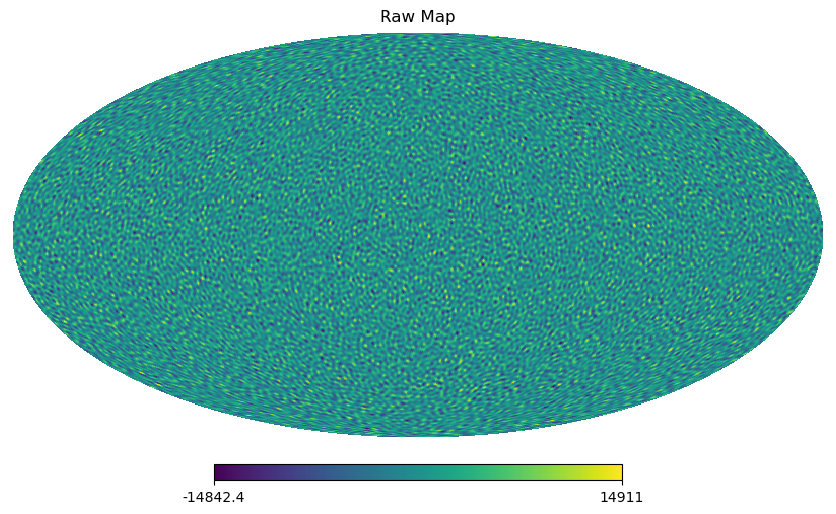

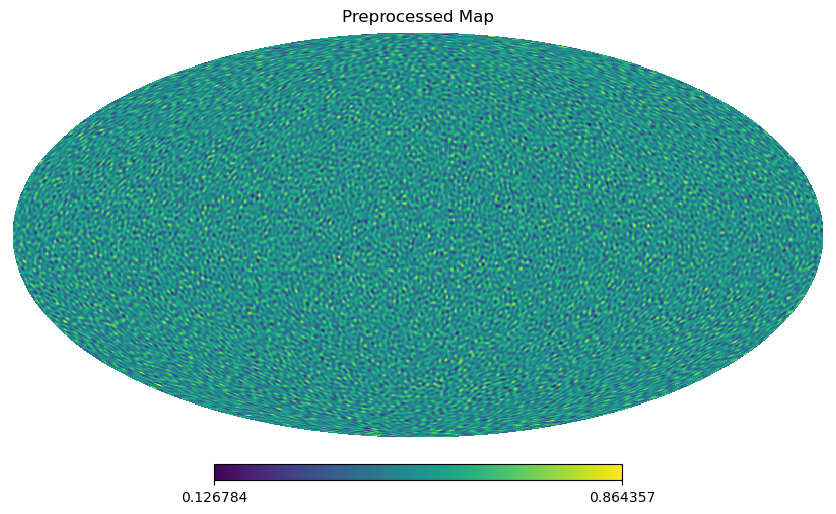

In [48]:
import matplotlib.pyplot as plt

hp.mollview(out_raw_map[0], title="Raw Map")
plt.show()

hp.mollview(out_prep_map[0], title="Preprocessed Map")
plt.show()

Those look good to me! Note that the true maximum and minimum values reported will not match the scale bars. The scale bars are the maximum and minimum for the data *as projected to the map*, and so they are often the average of some number of map pixels.

# Conclusion

This notebook illustrated several different structures of Executors. To recap

- A **basic executor** runs once, producing one asset globally and doesn't consider different simulations
- A **serial executor** iterates over simulations one-by-one. It may be slow, but it's appropriate when parallelization doesn't work, such as when a method in another library already uses multiple threads (e.g., ANAFAST)
- A **parallel executor** iterates over simulations by creating tasks and worker threads to process each task. It can be much faster, but more complicated.
- A **PyTorch-centric executor** iterates over simulations using PyTorch's Dataset class. It's ideal for machine learning, but more complicated.

The examples in this notebook are simplified versions of the ones practically used. For a more in-depth looks at the different styles, here's a list of modules to serve as reasonable prototypes.

Basic Executor:
- [Downloading External Science Assets](../get_data/stage_executors/A_get_assets.py)
- [Checking Hydra Configs before Simulations](../cmbml/sims/stage_executors/A_check_sims_hydra_configs.py)
- [Making the Noise Cache for Simulations](../cmbml/sims/stage_executors/B_make_noise_cache.py)
- [Final Comparison of Pixel-Space Results](../cmbml/analysis/stage_executors/_13_pixel_compare_table.py)

Serial Executor:
- [Simulation of Observations](../cmbml/sims/stage_executors/H_make_observations.py)
- [Simulation of Noise](../cmbml/sims/stage_executors/I_make_noise.py)
- [Simulation of Power Spectra](../cmbml/sims/stage_executors/G_make_power_spectra.py)
- [Making PyILC Predictions](../cmbml/pyilc_local/B_predict_executor.py)
- [Preprocessing cmbNNCS](../cmbml/cmbnncs_local/stage_executors/C_preprocess_nonparallel.py)
- [Postprocessing cmbNNCS](../cmbml/cmbnncs_local/stage_executors/F_postprocess_nonparallel.py)
- [Scanning for PatchNN](../cmbml/demo_patch_nn/stage_executors/C_find_dataset_stats_serial.py)
- [Preprocessing for PatchNN](../cmbml/demo_patch_nn/stage_executors/D_preprocess_patches_serial.py)
- [Postprocessing Common](../cmbml/analysis/stage_executors/D_common_map_post.py) (Common for all methods)
- [Analysis: Producing Power Spectra](../cmbml/analysis/stage_executors/K_make_pred_ps.py)

Parallel Executor:
- [Preprocessing for cmbNNCS](../cmbml/cmbnncs_local/stage_executors/C_preprocess.py)
- [Postprocessing cmbNNCS](../cmbml/cmbnncs_local/stage_executors/F_postprocess.py)
- [Scanning for PatchNN](../cmbml/demo_patch_nn/stage_executors/C_find_dataset_stats_parallel.py)
- [Analysis: Pixel-level Statistics](../cmbml/analysis/stage_executors/F_pixel_analysis.py)
- [Analysis: Power Spectrum Statistics](../cmbml/analysis/stage_executors/L_ps_analysis.py)

PyTorch-Centric Executor:
- [Training cmbNNCS](../cmbml/cmbnncs_local/stage_executors/D_train.py)
- [Prediction cmbNNCS](../cmbml/cmbnncs_local/stage_executors/E_predict.py)
- [Training PatchNN](../cmbml/demo_patch_nn/stage_executors/E_train.py)
- [Training PatchNN, without advance Preprocessing](../cmbml/demo_patch_nn/stage_executors/E_train_no_preprocess.py)
- [Prediction PatchNN](../cmbml/demo_patch_nn/stage_executors/F_predict.py)

I hope that this has been helpful. I have one more notebook that I'd like to put together, which will cover:
- Different detector frequencies
- How PySM3 is used
- How matplotlib is used